In [ ]:
pip install python-docx

In [ ]:
from docx import Document
from PIL import Image, ImageDraw, ImageFont
import os
import re
import numpy as np
import torch
import pandas as pd
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load OCR wikipedia page
doc = Document("/content/drive/MyDrive/Captcha/Optical_character_recognition.docx")

In [ ]:
# Get all the individual words in the document

words = []
for para in doc.paragraphs:
    for word in para.text.split():
        words.append(word)

print(words)
print(len(words))

['Optical', 'character', 'recognition', 'Optical', 'character', 'recognition', 'or', 'optical', 'character', 'reader', '(OCR)', 'is', 'the', 'electronic', 'or', 'mechanical', 'conversion', 'of', 'images', 'of', 'typed,', 'handwritten', 'or', 'printed', 'text', 'into', 'machine-encoded', 'text,', 'whether', 'from', 'a', 'scanned', 'document,', 'a', 'photo', 'of', 'a', 'document,', 'a', 'scene', 'photo', '(for', 'example', 'the', 'text', 'on', 'signs', 'and', 'billboards', 'in', 'a', 'landscape', 'photo)', 'or', 'from', 'subtitle', 'text', 'superimposed', 'on', 'an', 'image', '(for', 'example:', 'from', 'a', 'television', 'broadcast).[1]', 'Widely', 'used', 'as', 'a', 'form', 'of', 'data', 'entry', 'from', 'printed', 'paper', 'data', 'records', '–', 'whether', 'passport', 'documents,', 'invoices,', 'bank', 'statements,', 'computerized', 'receipts,', 'Video', 'of', 'the', 'process', 'of', 'scanning', 'and', 'real-time', 'optical', 'character', 'recognition', '(OCR)', 'with', 'a', 'portabl

In [ ]:
# Remove links, words with brackets, hyphens etc
cleaned = [w for w in words if re.fullmatch(r"[A-Za-z0-9]+", w)]

In [ ]:
len(cleaned), max(cleaned, key=len), cleaned.index(max(cleaned))

(3145, 'counterclockwise', 1016)

In [ ]:
# Load the pre-downloaded fonts
font_types = {
    'Arial': '/content/drive/MyDrive/Captcha/Fonts/ARIAL.TTF',
    'Comic Sans': '/content/drive/MyDrive/Captcha/Fonts/COMIC.TTF',
    'Courier': '/content/drive/MyDrive/Captcha/Fonts/Courier.ttf',
    'Georgia': '/content/drive/MyDrive/Captcha/Fonts/georgia.ttf',
    'Times': '/content/drive/MyDrive/Captcha/Fonts/times.ttf',
    'Open Sans': '/content/drive/MyDrive/Captcha/Fonts/OpenSans-VariableFont_wdth,wght.ttf',
    'Graffiti': '/content/drive/MyDrive/Captcha/Fonts/Graffiti Stream Extrude.otf',
    'Lucy': '/content/drive/MyDrive/Captcha/Fonts/Lucy Said Ok Personal Use.ttf',
    'Kenjaku': '/content/drive/MyDrive/Captcha/Fonts/Kenjaku DEMO.otf',
    'Caveat': '/content/drive/MyDrive/Captcha/Fonts/Caveat-VariableFont_wght.ttf'
}

len(font_types)

10

In [ ]:
# Convert all the words to lowercase to avoid duplication
cleaned_uni = list(dict.fromkeys([word.lower() for word in cleaned]))

In [ ]:
# Number of unique words after all the cleaning, word with the maximum length, index of word
len(cleaned_uni), max(cleaned_uni, key=len), cleaned_uni.index(max(cleaned_uni))

(988, 'counterclockwise', 422)

In [ ]:
# Select only the first 100 words
cleaned_100 = cleaned_uni[:100]

longest_word = max(cleaned_100, key=len)

len(cleaned_100), max(cleaned_100, key=len), cleaned_100.index(max(cleaned_100))

(100, 'electronically', 87)

In [ ]:
# Create a number of each word for classification purposes

num_to_word = dict(zip(range(0, 100), cleaned_100))
word_to_num = dict(zip(cleaned_100, range(0, 100)))

num_to_word, word_to_num

({0: 'optical',
  1: 'character',
  2: 'recognition',
  3: 'or',
  4: 'reader',
  5: 'is',
  6: 'the',
  7: 'electronic',
  8: 'mechanical',
  9: 'conversion',
  10: 'of',
  11: 'images',
  12: 'handwritten',
  13: 'printed',
  14: 'text',
  15: 'into',
  16: 'whether',
  17: 'from',
  18: 'a',
  19: 'scanned',
  20: 'photo',
  21: 'scene',
  22: 'example',
  23: 'on',
  24: 'signs',
  25: 'and',
  26: 'billboards',
  27: 'in',
  28: 'landscape',
  29: 'subtitle',
  30: 'superimposed',
  31: 'an',
  32: 'image',
  33: 'television',
  34: 'widely',
  35: 'used',
  36: 'as',
  37: 'form',
  38: 'data',
  39: 'entry',
  40: 'paper',
  41: 'records',
  42: 'passport',
  43: 'bank',
  44: 'computerized',
  45: 'video',
  46: 'process',
  47: 'scanning',
  48: 'with',
  49: 'portable',
  50: 'scanner',
  51: 'business',
  52: 'any',
  53: 'suitable',
  54: 'documentation',
  55: 'it',
  56: 'common',
  57: 'method',
  58: 'digitizing',
  59: 'texts',
  60: 'so',
  61: 'that',
  62: 'they',
 

In [ ]:
# Find the font which takes the maximum area for the longest word for upper case
areas = []

for font_type in font_types:
    font = ImageFont.truetype(font_types[font_type], size=20)

    dummy_img = Image.new("RGB", (1, 1))
    draw = ImageDraw.Draw(dummy_img)
    bbox = draw.textbbox((0, 0), longest_word.upper(), font=font)

    longest_word_width, longest_word_height = bbox[2] - bbox[0], bbox[3] - bbox[1]
    ar = longest_word_width * longest_word_height

    areas.append(ar)

    print(font_type, longest_word_height, longest_word_width, ar)
print()

largest_font_type = list(font_types.keys())[areas.index(max(areas))]

# Longest word and the largest font
longest_word, largest_font_type

Arial 15 177 2655
Comic Sans 17 178 3026
Courier 11 168 1848
Georgia 14 179 2506
Times 14 176 2464
Open Sans 14 163 2282
Graffiti 17 124 2108
Lucy 25 185 4625
Kenjaku 16 128 2048
Caveat 16 136 2176



('electronically', 'Lucy')

In [ ]:
def round_up_even(x):
    return int(math.ceil(x / 2) * 2)

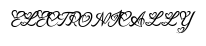

In [ ]:
# Create an image with the longest word and largest font to get the largest image size

dummy_img = Image.new("RGB", (1, 1))
draw = ImageDraw.Draw(dummy_img)

largest_font = ImageFont.truetype(font_types[largest_font_type], size=20)

bbox = draw.textbbox((0, 0), longest_word.upper(), font=largest_font)

longest_word_width, longest_word_height = bbox[2] - bbox[0], bbox[3] - bbox[1]

padding = 10
img = Image.new("RGB", (round_up_even(longest_word_width) + padding*2, round_up_even(longest_word_height) + padding*2), "white")
draw = ImageDraw.Draw(img)
draw.text(((img.size[0] - longest_word_width)/2, (img.size[1] - longest_word_height)/2), longest_word.upper(), fill="black", font=largest_font)

img

In [ ]:
# Get the size of the image which is to be applied to all the words for all fonts
size = img.size

size

(206, 46)

In [ ]:
# path of the folder to save the easy dataset
output_dir_easy = r'/content/drive/MyDrive/Captcha/easy_set'

In [ ]:
# List to save the paths to each image, label, and number
csv_data_easy = []

In [ ]:
for word in cleaned_100:
    for font_type in font_types:
        dummy_img = Image.new("RGB", (1, 1))
        draw = ImageDraw.Draw(dummy_img)

        # Dimensions of each word for each font with fixed font size
        font = ImageFont.truetype(font_types[font_type], size=20)
        bbox = draw.textbbox((0, 0), word, font=font)

        word_width, word_height = bbox[2] - bbox[0], bbox[3] - bbox[1]

        # Create the image with fixed size by centering the word in the font and size
        img = Image.new("RGB", size, "white")
        draw = ImageDraw.Draw(img)
        draw.text(((img.size[0] - word_width)/2, (img.size[1] - word_height)/2), word, fill="black", font=font)

        filename = f'{font_type}_{word}.png'

        full_filename = os.path.join(output_dir_easy, filename)

        number = word_to_num[word.lower()]
        csv_data_easy.append([full_filename, word, number])

        print(full_filename, word, number)
        img.save(full_filename)
    print()

/content/drive/MyDrive/Captcha/easy_set/Arial_optical.png optical 0
/content/drive/MyDrive/Captcha/easy_set/Comic Sans_optical.png optical 0
/content/drive/MyDrive/Captcha/easy_set/Courier_optical.png optical 0
/content/drive/MyDrive/Captcha/easy_set/Georgia_optical.png optical 0
/content/drive/MyDrive/Captcha/easy_set/Times_optical.png optical 0
/content/drive/MyDrive/Captcha/easy_set/Open Sans_optical.png optical 0
/content/drive/MyDrive/Captcha/easy_set/Graffiti_optical.png optical 0
/content/drive/MyDrive/Captcha/easy_set/Lucy_optical.png optical 0
/content/drive/MyDrive/Captcha/easy_set/Kenjaku_optical.png optical 0
/content/drive/MyDrive/Captcha/easy_set/Caveat_optical.png optical 0

/content/drive/MyDrive/Captcha/easy_set/Arial_character.png character 1
/content/drive/MyDrive/Captcha/easy_set/Comic Sans_character.png character 1
/content/drive/MyDrive/Captcha/easy_set/Courier_character.png character 1
/content/drive/MyDrive/Captcha/easy_set/Georgia_character.png character 1
/con

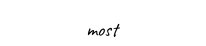

In [ ]:
img

In [ ]:
word

'most'

In [ ]:
# Convert the list to a csv file
df = pd.DataFrame(csv_data_easy, columns=["filename", "label", "number"])

df

,filename,label,number
0,/content/drive/MyDrive/Captcha/easy_set/Arial_...,optical,0
1,/content/drive/MyDrive/Captcha/easy_set/Comic ...,optical,0
2,/content/drive/MyDrive/Captcha/easy_set/Courie...,optical,0
3,/content/drive/MyDrive/Captcha/easy_set/Georgi...,optical,0
4,/content/drive/MyDrive/Captcha/easy_set/Times_...,optical,0
...,...,...,...
995,/content/drive/MyDrive/Captcha/easy_set/Open S...,most,99
996,/content/drive/MyDrive/Captcha/easy_set/Graffi...,most,99
997,/content/drive/MyDrive/Captcha/easy_set/Lucy_m...,most,99
998,/content/drive/MyDrive/Captcha/easy_set/Kenjak...,most,99


In [ ]:
df.to_pickle(os.path.join(r'/content/drive/MyDrive/Captcha', 'labels_easy.pkl'))

In [ ]:
df.to_csv(os.path.join(r'/content/drive/MyDrive/Captcha', 'labels_easy.csv'), index=False)

In [ ]:
# Backgrounds and their paths

textures = {0: '',
            1: r'/content/drive/MyDrive/Captcha/Textures/# #moon background # #background #wallpaper….jpg',
            2: r'/content/drive/MyDrive/Captcha/Textures/ANwme5XI.jpg',
            3: r'/content/drive/MyDrive/Captcha/Textures/CUgr9ZaF.jpg'}

len(textures)

4

In [ ]:
# 5 different noise levels(std)
noise_lvls = [0, 12.5, 25, 37.5, 50]

len(noise_lvls)

5

In [ ]:
# 5 Font colours
colours = ['black',
           'red',
           'green',
           'blue',
           'orange']

len(colours)

5

In [ ]:
# Function to randomly capitalize(lower/upper) a word
# Generator function to ensure reproducibility

seed = 0
gen = torch.Generator().manual_seed(seed)

def rand_cap(word: str):
    return "".join(
        ch.upper() if torch.randint(0, 2, (1, ), generator=gen).item() else ch.lower()
        for ch in word
    )

In [ ]:
# path of the folder to save the hard dataset
output_dir_hard = '/content/drive/MyDrive/Captcha/Hard_set'

In [ ]:
# List to save the paths to each image, label, and number
csv_data_hard = []

In [ ]:
for i in range(len(textures)):
    for background in list(textures.keys())[i: i + 1]:
        for font_type in font_types:
            for word in cleaned_100:
                for std in noise_lvls:
                    for colour in colours:

                        # If the background is empty create a white background otherise load image according to the sizep
                        if background != 0:
                            img = Image.open(textures[background]).convert("RGB")
                            img = img.resize(size)
                        else:
                            img = Image.new("RGB", size, "white")
                            draw = ImageDraw.Draw(img)

                        arr = np.array(img).astype(np.float32)

                        # Add Gaussian noise according to different noise levels
                        mean = 0
                        noise = np.random.normal(mean, std, arr.shape)

                        noisy_arr = arr + noise
                        noisy_arr = np.clip(noisy_arr, 0, 255).astype(np.uint8)
                        noisy_img = Image.fromarray(noisy_arr)

                        font = ImageFont.truetype(font_types[font_type], size=24)

                        # Randomly change the capitilize the word
                        word = rand_cap(word)

                        # Find the dimensions of the word with font
                        bbox = draw.textbbox((0, 0), word, font=font)
                        word_width, word_height = bbox[2] - bbox[0], bbox[3] - bbox[1]

                        # Draw the text and center it
                        draw = ImageDraw.Draw(noisy_img)
                        draw.text(((img.size[0] - word_width)/2, (img.size[1] - word_height)/2), word, fill=colour, font=font)

                        # Name the file accordingly
                        filename = f'{background}_{font_type}_{std}_{colour}_{word}.png'
                        output_dir = output_dir = output_dir_hard + '/' + str(i)

                        # path for each image
                        full_filename = os.path.join(output_dir, filename)

                        # Save the image path, word with same capitalization, number
                        number = word_to_num[word.lower()]
                        csv_data_hard.append([full_filename, word, number])

                        #noisy_img.save(full_filename)

In [ ]:
csv_data_hard

[['/content/drive/MyDrive/Captcha/Hard_set/0_Arial_0_black_optical.png',
  'optical',
  0],
 ['/content/drive/MyDrive/Captcha/Hard_set/0_Arial_0_red_optical.png',
  'optical',
  0],
 ['/content/drive/MyDrive/Captcha/Hard_set/0_Arial_0_green_optical.png',
  'optical',
  0],
 ['/content/drive/MyDrive/Captcha/Hard_set/0_Arial_0_blue_optical.png',
  'optical',
  0],
 ['/content/drive/MyDrive/Captcha/Hard_set/0_Arial_0_orange_optical.png',
  'optical',
  0],
 ['/content/drive/MyDrive/Captcha/Hard_set/0_Arial_12.5_black_optical.png',
  'optical',
  0],
 ['/content/drive/MyDrive/Captcha/Hard_set/0_Arial_12.5_red_optical.png',
  'optical',
  0],
 ['/content/drive/MyDrive/Captcha/Hard_set/0_Arial_12.5_green_optical.png',
  'optical',
  0],
 ['/content/drive/MyDrive/Captcha/Hard_set/0_Arial_12.5_blue_optical.png',
  'optical',
  0],
 ['/content/drive/MyDrive/Captcha/Hard_set/0_Arial_12.5_orange_optical.png',
  'optical',
  0],
 ['/content/drive/MyDrive/Captcha/Hard_set/0_Arial_25_black_optical.p

In [ ]:
len(csv_data_hard)

100000

In [ ]:
os.path.join(r'/content/drive/MyDrive/Captcha', 'labels_Hard_0123.csv')

'/content/drive/MyDrive/Captcha/labels_Hard_0123.csv'

In [ ]:
# Save the the list as csv file image paths, labels with words, numbers
df = pd.DataFrame(csv_data_hard, columns=["filename", "label", "number"])

#df.to_csv(os.path.join(r'/content/drive/MyDrive/Captcha', 'labels_Hard_0123.csv'), index=False)

In [ ]:
df0 = pd.read_csv('/content/drive/MyDrive/Captcha/labels_Hard_0.csv')
df1 = pd.read_csv('/content/drive/MyDrive/Captcha/labels_Hard_1.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Captcha/labels_Hard_2.csv')
df3 = pd.read_csv('/content/drive/MyDrive/Captcha/labels_Hard_3.csv')
#df4 = pd.read_csv('/content/drive/MyDrive/Captcha/labels_Hard_4.csv')

In [ ]:
df_hard = pd.concat([df0, df1], ignore_index=True)

In [ ]:
df_hard

,filename,label,number
0,/content/drive/MyDrive/Captcha/Hard_set/0/0_Ar...,oPTiCAL,0
1,/content/drive/MyDrive/Captcha/Hard_set/0/0_Ar...,OPTIcaL,0
2,/content/drive/MyDrive/Captcha/Hard_set/0/0_Ar...,opticAl,0
3,/content/drive/MyDrive/Captcha/Hard_set/0/0_Ar...,OPtiCAL,0
4,/content/drive/MyDrive/Captcha/Hard_set/0/0_Ar...,OpTiCaL,0
...,...,...,...
49995,/content/drive/MyDrive/Captcha/Hard_set/1/1_Ca...,MosT,99
49996,/content/drive/MyDrive/Captcha/Hard_set/1/1_Ca...,mosT,99
49997,/content/drive/MyDrive/Captcha/Hard_set/1/1_Ca...,moSt,99
49998,/content/drive/MyDrive/Captcha/Hard_set/1/1_Ca...,moSt,99


In [ ]:
df_hard.to_csv(os.path.join(r'/content/drive/MyDrive/Captcha', 'labels_Hard_01.csv'), index=False)